In [14]:
import pandas as pd
import numpy as np
import statsmodels.tsa.seasonal
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go

In [11]:
def run_sequence_plot(x, y, title, xtitle, ytitle):
    figure = px.line(x=x, y=y)
    figure.update_layout(title=title, width=800, xaxis_title=xtitle, yaxis_title=ytitle)
    return figure


## Read parquet dataset

In [3]:
df = pd.read_parquet("data/household.parquet")

# Exclude data before July 2007
df = df.loc["2007-07":]

In [12]:
df_monthly = df.resample("M").quantile(0.99)
var = "Global_active_power"
fig = run_sequence_plot(
    df_monthly.index, df_monthly[var], f"Monthly 99% percentile {var}", "Time", f"{var}"
)
fig.show()

## Triple Exponential Smoothing

In [16]:
train = df_monthly[var].iloc[:-10]
test = df_monthly[var].iloc[-10:]

In [17]:
# Fitting with 3x exponential smoothing to account for trend, seasons

from statsmodels.tsa.api import ExponentialSmoothing

triple_exp = ExponentialSmoothing(
    train, trend="add", seasonal="add", seasonal_periods=12
)

triple_exp = triple_exp.fit(optimized=True)

In [18]:
from sklearn.metrics import mean_squared_error

# Predict
test_predict = triple_exp.forecast(len(test))
mse_triple = mean_squared_error(test, test_predict)
print(f"Mean squared error: {mse_triple}")

Mean squared error: 0.15069800468530312


In [19]:
figure = px.line(x=df_monthly.index, y=df_monthly[var])
figure.add_scatter(x=test.index, y=test_predict, mode="lines")
figure.update_layout(
    title=f"Monthly 99% percentile {var}",
    width=800,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

### ARIMA
[ACF and PACF plots](https://otexts.com/fpp2/non-seasonal-arima.html#acf-and-pacf-plots)
From ACF and PACF:
- ARIMA(p,d,0) model: if ACF and PACF plots of the differenced data show the following: the ACF is exponentially decaying or sinusoidal; there is a significant spike at lag $p$
- ARIMA(0,d,q) model: if the PACF is exponentially decaying or sinusoidal; there is a significant spike at lag $q$ in the ACF, but none beyond lag $q$

It is hypothesized $p=1$.

### Let's start from ARMA models first

In [23]:
from statsmodels.tsa.arima.model import ARIMA

model_ARMA = ARIMA(endog=df_monthly[var], order=(1, 0, 0)).fit()
model_ARMA.params

const     4.594238
ar.L1     0.699169
sigma2    0.145126
dtype: float64

In [24]:
model_ARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   42
Model:                  ARIMA(1, 0, 0)   Log Likelihood                 -19.398
Date:                 Fri, 14 Jan 2022   AIC                             44.796
Time:                         17:33:09   BIC                             50.009
Sample:                     07-31-2007   HQIC                            46.707
                          - 12-31-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5942      0.203     22.672      0.000       4.197       4.991
ar.L1          0.6992      0.106      6.578      0.000       0.491       0.907
sigma2         0.1451      0.039      3.750      0.000       0.069       0.221
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.74   Prob(JB):                         0.64
Heteroskedasticity (H):               1.45   Skew:                            -0.18
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)
import seaborn as sns


def plot_data_acf_pacf(data, lags):
    layout = (1, 3)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    raw.plot(data)
    plot_acf(data, ax=acf, lags=lags, zero=False)
    plot_pacf(data, ax=pacf, lags=lags, zero=False, method="ywm")
    sns.despine()
    plt.tight_layout()

### Residuals from ARMA model

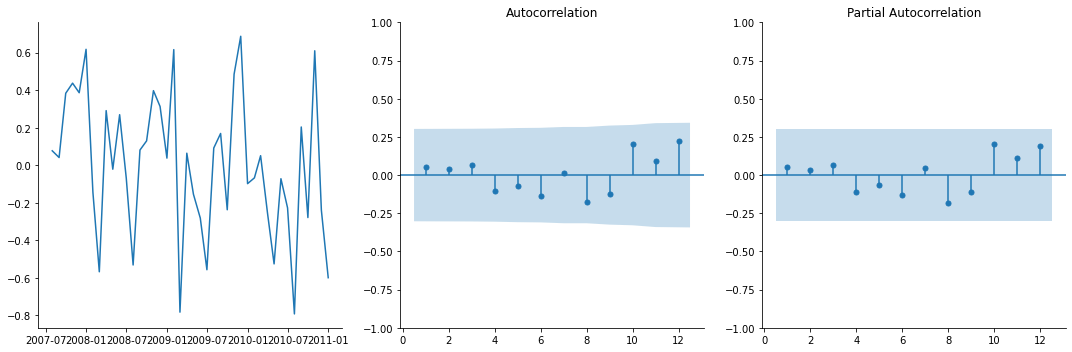

In [39]:
plot_data_acf_pacf(model_ARMA.resid[model_ARMA.loglikelihood_burn :], lags=12)

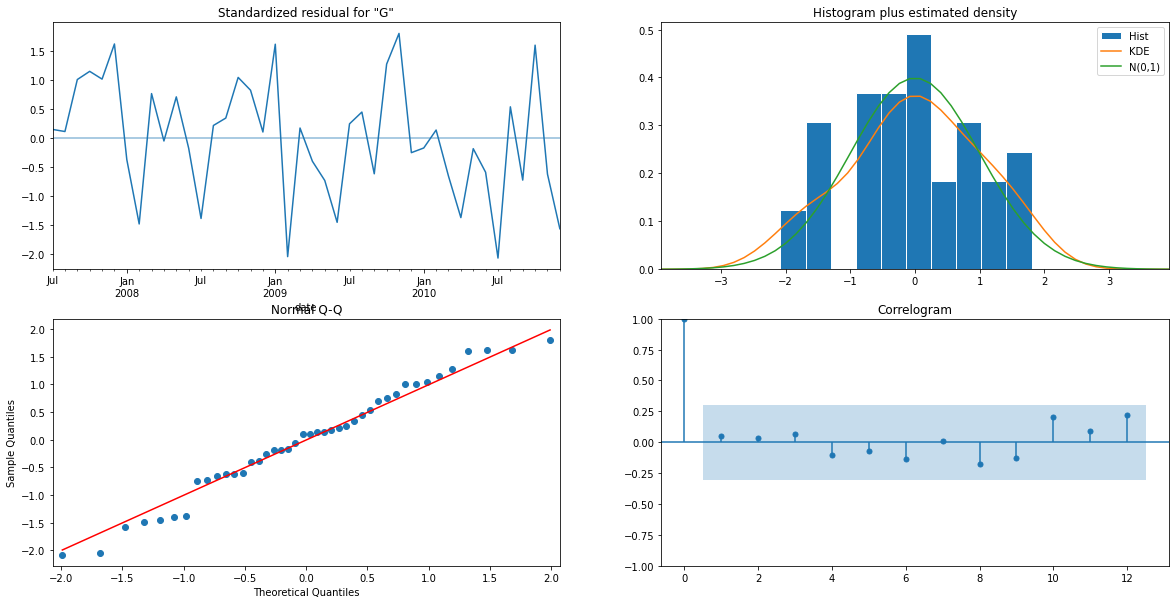

In [44]:
arma_diag = model_ARMA.plot_diagnostics(lags=12, figsize=(20, 10))

In [104]:
forecast_arma = model_ARMA.predict(start=len(df_monthly[0:-10]), end=len(df_monthly))

figure = px.line(x=df_monthly.index, y=df_monthly[var])
figure.add_scatter(x=forecast_arma.index, y=forecast_arma, mode="lines", name="arma")
figure.update_layout(
    title=f"Monthly 99% percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

## SARIMA

In [106]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sar = SARIMAX(
    train,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 12),
    trend="t",  # Linear trend
).fit()
sar.summary()

c:\users\andre\pycharmprojects\householdconsumption\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                  Global_active_power   No. Observations:                   32
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                  -8.307
Date:                              Fri, 14 Jan 2022   AIC                             24.614
Time:                                      19:01:11   BIC                             28.597
Sample:                                  07-31-2007   HQIC                            25.392
                                       - 02-28-2010                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0087      0.007     -1.213      0.225      -0.023       0.005
ar.L1          0.1261      0.427      0.296      0.768      -0.710       0.963
ma.S.L12      -0.7650      2.997     -0.255      0.798      -6.638       5.108
sigma2         0.0942      0.241      0.391      0.696      -0.378       0.566
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.96   Prob(JB):                         0.56
Heteroskedasticity (H):               1.42   Skew:                             0.57
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

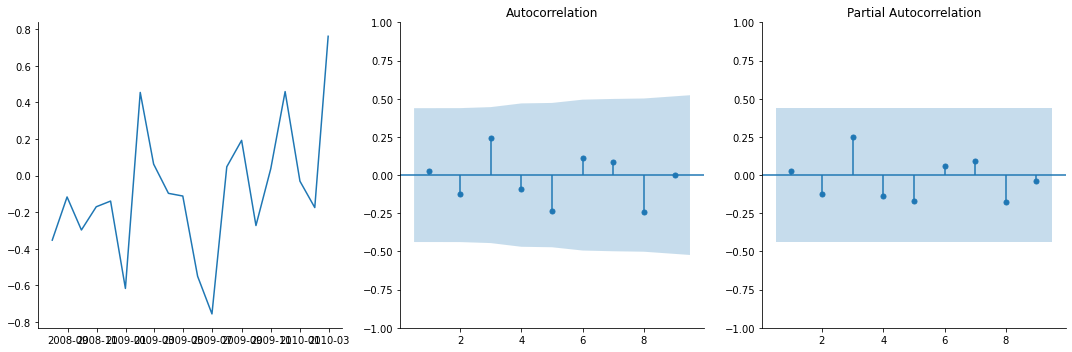

In [109]:
plot_data_acf_pacf(sar.resid[sar.loglikelihood_burn :], lags=9)

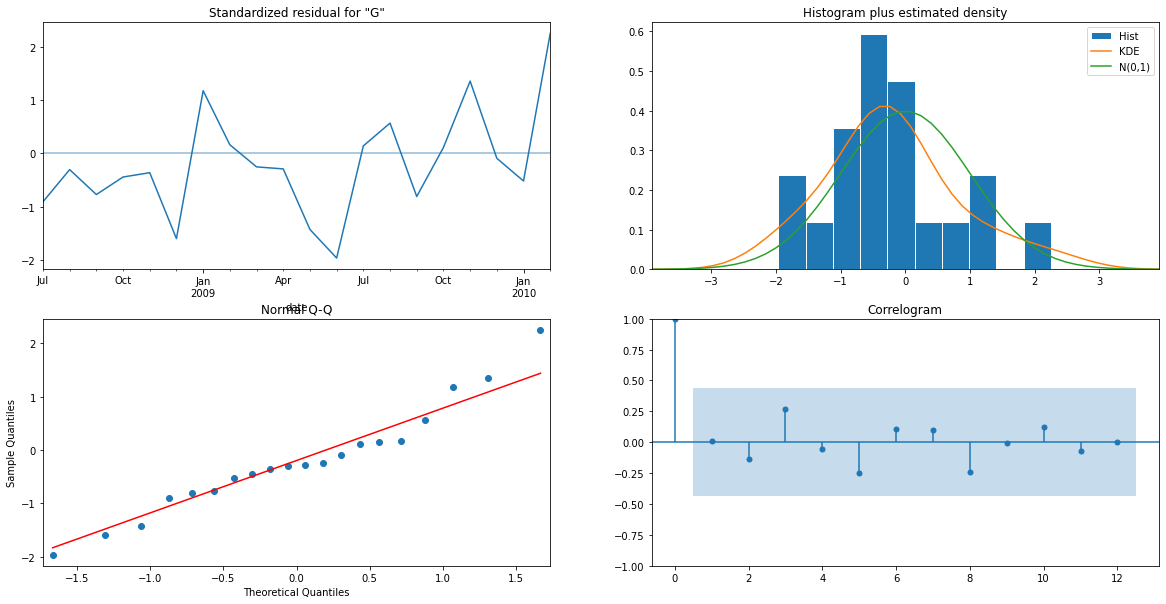

In [110]:
sar_diag = sar.plot_diagnostics(lags=12, figsize=(20, 10))

In [111]:
forecast_sar = sar.predict(start=len(df_monthly[0:-10]), end=len(df_monthly))

figure = px.line(x=df_monthly.index, y=df_monthly[var])
figure.add_scatter(x=forecast_sar.index, y=forecast_sar, mode="lines", name="sar")
figure.update_layout(
    title=f"Monthly 99% percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

### SARIMA longer term forecast

In [112]:

sar = SARIMAX(
    df_monthly[var],
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 12),
    trend="t",  # Linear trend
).fit()

# can use get forecast to create a forecast object
future = sar.get_forecast(12)

# That will have a method to pull in confidence interval
confidence_int = future.conf_int(alpha=0.05)

# Has an attribute to pull in predicted mean
fcst = future.predicted_mean

figure = px.line(x=df_monthly.index, y=df_monthly[var])
figure.add_scatter(x=fcst.index, y=fcst, mode="lines", name="sar future")

figure.add_scatter(x=fcst.index, y=confidence_int[f"lower {var}"], line=dict(width=0), mode="lines", showlegend=False)
figure.add_scatter(x=fcst.index, y=confidence_int[f"upper {var}"], line=dict(width=0), mode="lines", fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False)

figure.update_layout(
    title=f"Monthly 99% percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

c:\users\andre\pycharmprojects\householdconsumption\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



## Auto ARIMA

In [113]:
from pmdarima import auto_arima

auto_model = auto_arima(
    df_monthly[var],
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=True,
    D=1,
    max_D=3,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=30.569, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=32.529, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=27.663, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=29.479, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=46.182, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=33.763, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=29.046, Time=0.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=29.046, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=29.933, Time=0.08 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=31.046, Time=0.25 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=26.105, Time=0.04 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=27.611, Time=1.60 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=27.611, Time=0.17 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=28.421, Time=0.08 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=29.6

In [70]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   42
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 -10.052
Date:                  Fri, 14 Jan 2022   AIC                             26.105
Time:                          18:30:01   BIC                             30.308
Sample:                               0   HQIC                            27.449
                                   - 42                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4780      0.066     -7.276      0.000      -0.607      -0.349
ar.S.L12      -0.6432      0.246     -2.612      0.009      -1.126      -0.161
sigma2         0.0924      0.024      3.849      0.000       0.045       0.139
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.46   Prob(JB):                         0.54
Heteroskedasticity (H):               2.43   Skew:                             0.29
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

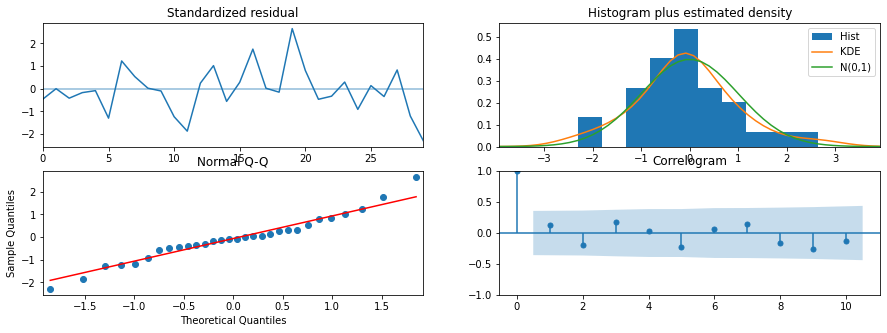

In [56]:
auto_diag = auto_model.plot_diagnostics()

In [63]:
print(f'auto-fit order: {auto_model.order}')
print(f'auto-fit seasonal_order: {auto_model.seasonal_order}')

auto-fit order: (0, 0, 0)
auto-fit seasonal_order: (1, 1, 0, 12)


### Auto ARIMA forecast

In [114]:
fc, conf_int = auto_model.predict(n_periods=10, return_conf_int=True)

# Updates the existing model with a small number of MLE steps
auto_model.update(test)

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True)

In [115]:


figure = px.line(x=df_monthly.index, y=df_monthly[var])
figure.add_scatter(x=test.index, y=fc, mode="lines", name="auto arima")

figure.add_scatter(x=test.index, y=conf_int[:,1], line=dict(width=0), mode="lines", showlegend=False)
figure.add_scatter(x=test.index, y=conf_int[:,0], line=dict(width=0), mode="lines", fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False)

figure.update_layout(
    title=f"Monthly 99% percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()

In [116]:
future_auto, conf_int_future = auto_model.predict(n_periods=10, return_conf_int=True)

In [123]:

start = df_monthly.index.max() + pd.DateOffset(months=1)
new_index = pd.date_range(start, periods=10, freq='M')
figure = px.line(x=df_monthly.index, y=df_monthly[var])
figure.add_scatter(x=new_index, y=future_auto, mode="lines", name="auto arima")


figure.add_scatter(x=new_index, y=conf_int_future[:,1], line=dict(width=0), mode="lines", showlegend=False)
figure.add_scatter(x=new_index, y=conf_int_future[:,0], line=dict(width=0), mode="lines", fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False)

figure.update_layout(
    title=f"Monthly 99% percentile {var}",
    width=1000,
    xaxis_title="Time",
    yaxis_title=f"{var}",
)
figure.show()